In [30]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from tqdm.auto import trange

<h3>Создание датасета</h3>

In [31]:
from navec import Navec

path = '../../static/embeddings/navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [32]:
train_data = pd.read_csv('../../static/datasets/original/validation_data_labeled.csv', sep='\t')
sentences = train_data.sentence
emb = np.zeros((len(sentences), 100))
words = [0]
for i in range(len(sentences)):
    sentence = sentences[i].split(" ")
    for j in range(len(sentence)):
        words.append(sentence[j])
        emb[i][j] = len(a) - 1

In [33]:
X = emb
y = pd.DataFrame(train_data['label'])
y.replace(1, 2, inplace=True)
y.replace(0, 1, inplace=True)
y.replace(-1, 0, inplace=True)
y = np.array(y)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [35]:
xt = np.zeros((len(X_train), 100, 300))
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        if X_train[i][j] != 0:
            if a[int(X_train[i][j])] in navec:
                xt[i][j] = navec[a[int(X_train[i][j])]]
X_train = xt

In [36]:
xt = np.zeros((len(X_val), 100, 300))
for i in range(len(X_val)):
    for j in range(len(X_val[i])):
        if X_val[i][j] != 0:
            if len(a) <= int(X_val[i][j]):
                print(int(X_val[i][j]))
            if a[int(X_val[i][j])] in navec:
                xt[i][j] = navec[a[int(X_val[i][j])]]
X_val = xt

In [37]:
def df_to_tensor(df):
    return torch.from_numpy(df.values).float()

In [38]:
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_val_t = torch.from_numpy(X_val)
y_val_t = torch.from_numpy(y_val)
X_train_t = torch.permute(X_train_t, (0, 2, 1))
X_val_t = torch.permute(X_val_t, (0, 2, 1))

In [39]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=25, shuffle=True)


<h3>Обучение</h3>

In [40]:
import gc   

def free_cache(X_batch=None, y_batch=None):
    if X_batch is not None:
        del X_batch
    if y_batch is not None:
        del y_batch
    torch.cuda.empty_cache()
    gc.collect()
            

In [41]:
from sklearn import metrics as multi_metrics

def calc_f1(probs, y_true) -> float:
    _, pred = torch.max(probs, axis=-1)
    pred = pred.to('cpu')
    y_true = y_true.to('cpu')
    return multi_metrics.f1_score(y_true=y_true, y_pred=pred, average='macro')
    

def get_f1(model, X_batch, y_batch) -> float:
    model.eval()
    X_batch = X_batch.to(device)
    probs = model(X_batch.float())
    return calc_f1(probs, y_batch)

In [42]:
def fit(epochs, model_, loss_func, opt, train_dl, valid_dl, lr_sched=None):
    model_ = model_.to(device)
    train_losses = []
    val_losses = []
    valid_accuracies = []
    pbar = trange(epochs, desc="Epoch:")
    for epoch in pbar:
        model_.train()
        loss_sum = 0

        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            yb = yb.view(-1)
            probs = model_(xb.float())
            
            loss = loss_func(probs, yb)
            loss_sum += loss.item()
            loss.backward()

            opt.step()
            opt.zero_grad()
            free_cache(xb, yb)

        train_losses.append(loss_sum / len(train_dl))


        model_.eval()
        loss_sum = 0
        count_batches = 0
        sum_f1 = 0

        with torch.no_grad():
            for xb, yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                yb = yb.view(-1)
                probs = model_(xb.float())

                loss = loss_func(probs, yb)
                loss_sum += loss.item()
                
                sum_f1 += calc_f1(probs, yb)
                free_cache(xb, yb)
                count_batches += 1

        
        val_loss = loss_sum / len(valid_dl)
        val_f1 = sum_f1 / count_batches
        val_losses.append(val_loss)
        valid_accuracies.append(val_f1)

        pbar.set_description('Epoch: {} Loss: {:.4f} AverageF1: {:.4f}'.format(epoch, val_loss, val_f1))

        #torch.save(model.state_dict(), PATH)   #сохранение весов модели на будущее

        if lr_sched is not None:
            lr_sched.step()

    return train_losses, val_losses, valid_accuracies

<h3>Модель</h3>

Load Model:
    model = TheModelClass(*args, **kwargs)
    model.load_state_dict(torch.load(PATH))
    model.eval()

In [55]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self):
        super(MultiLayerPerceptron, self).__init__()
        # Embedding size, Hyperparameter, Output
        self.conv1 = nn.Conv1d(in_channels=300, out_channels=300, kernel_size=7) #94
        self.pool = nn.MaxPool1d(kernel_size=3, stride=3) #31
        self.conv2 = nn.Conv1d(in_channels=300, out_channels=300, kernel_size=5) #27
        #9
        self.conv3 = nn.Conv1d(in_channels=300, out_channels=300, kernel_size=3, padding=1) #9
        #3
        #self.conv4 = nn.Conv1d(in_channels=300, out_channels=300, kernel_size=3, padding=1) #12
        #6
        #self.conv5 = nn.Conv1d(in_channels=300, out_channels=300, kernel_size=3) #4
        #4
        self.fc1 = nn.Linear(3*300, 2048)
        self.fc2 = nn.Linear(2048, 3)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        #x = self.pool(F.leaky_relu(self.conv4(x)))
        #x = F.leaky_relu(self.conv5(x))
        x = x.view(-1, 3*300)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [56]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [57]:


model = MultiLayerPerceptron().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5)

In [58]:
info = fit(30, model, criterion, optimizer, train_dataloader, val_dataloader)

Epoch::   0%|          | 0/30 [00:00<?, ?it/s]

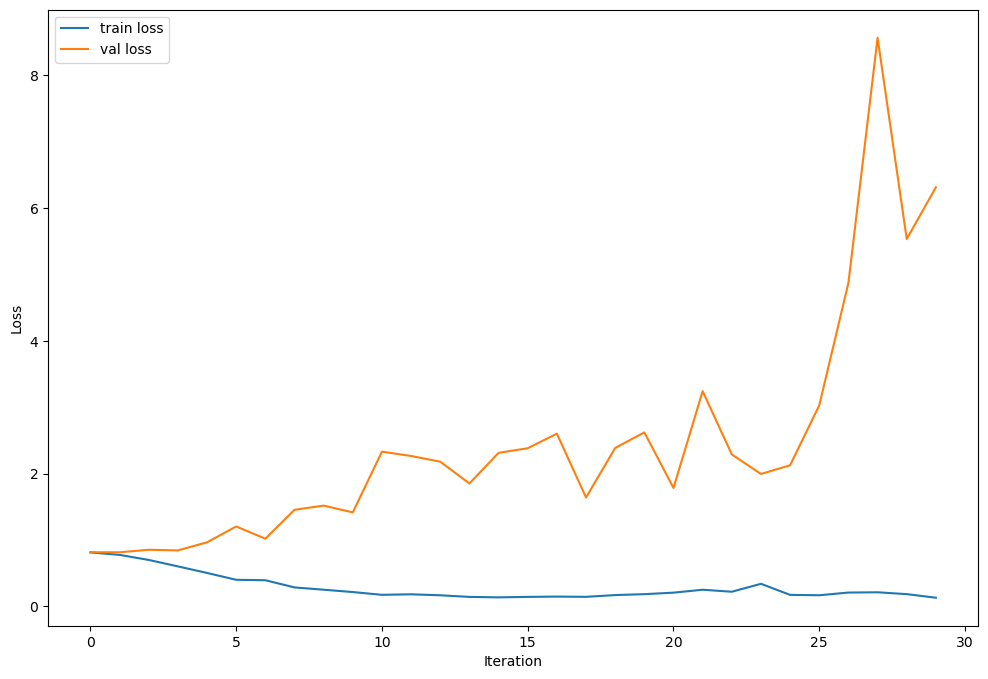

In [59]:
train_losses = info[0]
val_losses = info[1]
plt.figure(figsize=(12, 8))
plt.plot(range(len(train_losses)), train_losses, label='train loss')
plt.plot(range(len(val_losses)), val_losses, label='val loss')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

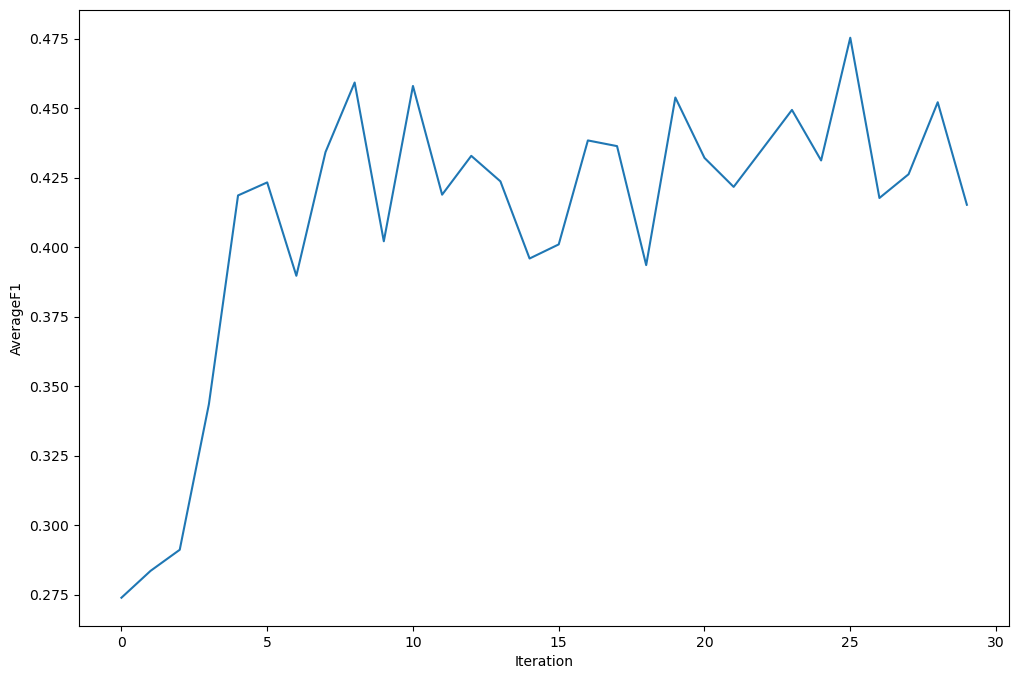

In [60]:
train_f1 = info[2]
plt.figure(figsize=(12, 8))
plt.plot(range(len(train_f1)), train_f1)
plt.xlabel("Iteration")
plt.ylabel("AverageF1")
plt.show()

In [188]:
import sys
sys.path.append('../..')

from sklearn import metrics as multi_metrics

In [189]:
model.eval()
xb, yb = next(iter(val_dataloader))
xb = xb.to(device)
probs = model(xb.float())
_, pred = torch.max(probs, axis=-1)